<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/Mamba's_Parallel_Associative_Scan_Mathematical_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PART 1: Understanding State Space Models

Continuous System Matrices:
A shape: (4, 4)
B shape: (4, 1)
C shape: (1, 4)

A eigenvalues (should have negative real parts):
[-2.+1.77161158j -2.-1.77161158j -2.+0.21816728j -2.-0.21816728j]

PART 2: Zero Order Hold Discretization

Discretization with different time steps:

Δ =  0.001 | Max |λ| of A_bar: 0.9980 (should be < 1 for stability)

Δ =  0.010 | Max |λ| of A_bar: 0.9802 (should be < 1 for stability)

Δ =  0.100 | Max |λ| of A_bar: 0.8187 (should be < 1 for stability)

Δ =  1.000 | Max |λ| of A_bar: 0.1353 (should be < 1 for stability)

Using Δ = 0.01 for subsequent experiments

PART 3: Sequential State Update

Sequential computation time: 2.13 ms
Input shape: (100, 1)
Output shape: (100, 1)
Hidden states shape: (100, 4)

PART 4: Parallel Associative Scan

Parallel scan computation time: 1.21 ms
Speedup vs sequential: 1.76x

Note: On CPU, speedup is modest. On GPU with proper parallelization,
speedup can be 10-100x for long sequences!


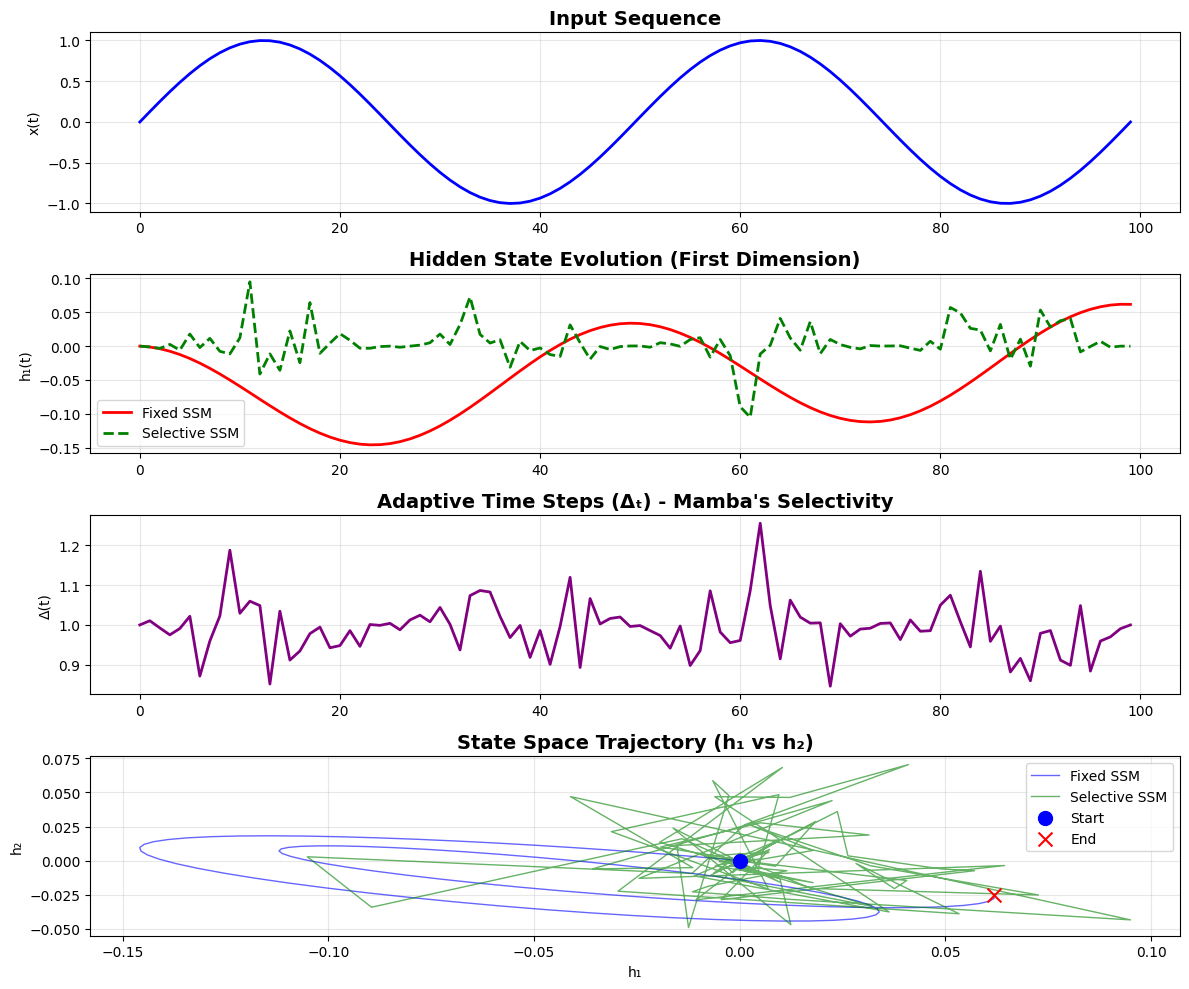


PART 7: Complexity Analysis Summary

┌─────────────────────┬──────────────┬──────────────┬─────────────┐
│ Method              │ Time         │ Memory       │ Parallelism │
├─────────────────────┼──────────────┼──────────────┼─────────────┤
│ RNN (Sequential)    │ O(n)         │ O(d)         │ None        │
│ Transformer         │ O(n²)        │ O(n²d)       │ Full        │
│ Mamba (Scan)        │ O(n log n)*  │ O(nd)        │ High        │
└─────────────────────┴──────────────┴──────────────┴─────────────┘

*On parallel hardware with optimal implementation

Experiment with different sequence lengths and parameters!
Modify the code above to see how Mamba scales.


In [1]:
"""
Mamba's Parallel Associative Scan - Mathematical Playground
============================================================

This notebook lets you experiment with the core mathematical operations
that power Mamba's efficient sequence modeling.

Run each cell in order to understand:
1. State Space Model basics
2. Zero Order Hold discretization
3. Parallel Associative Scan
4. Input-dependent selective mechanism
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time

# ============================================================================
# PART 1: State Space Model Basics
# ============================================================================

print("="*70)
print("PART 1: Understanding State Space Models")
print("="*70)

# Define a simple continuous SSM
# h'(t) = A h(t) + B x(t)
# y(t) = C h(t) + D x(t)

d = 4  # state dimension
n = 1  # input dimension

# Create a stable matrix A (eigenvalues with negative real parts)
np.random.seed(42)
A_continuous = np.random.randn(d, d) * 0.5
A_continuous = A_continuous - A_continuous.T  # make skew-symmetric (stable)
A_continuous = A_continuous - 2 * np.eye(d)   # shift eigenvalues left

B_continuous = np.random.randn(d, n)
C_continuous = np.random.randn(n, d)
D = np.random.randn(n, n) * 0.1

print(f"\nContinuous System Matrices:")
print(f"A shape: {A_continuous.shape}")
print(f"B shape: {B_continuous.shape}")
print(f"C shape: {C_continuous.shape}")
print(f"\nA eigenvalues (should have negative real parts):")
print(np.linalg.eigvals(A_continuous))

# ============================================================================
# PART 2: Zero Order Hold (ZOH) Discretization
# ============================================================================

print("\n" + "="*70)
print("PART 2: Zero Order Hold Discretization")
print("="*70)

def discretize_zoh(A, B, delta):
    """
    Discretize continuous SSM using Zero Order Hold method.

    A_bar = exp(A * delta)
    B_bar = (exp(A * delta) - I) * A^{-1} * B

    Args:
        A: Continuous state matrix (d x d)
        B: Continuous input matrix (d x n)
        delta: Time step size

    Returns:
        A_bar, B_bar: Discretized matrices
    """
    d = A.shape[0]
    I = np.eye(d)

    # Compute A_bar = exp(A * delta)
    A_bar = expm(A * delta)

    # Compute B_bar = (exp(A * delta) - I) * A^{-1} * B
    A_inv = np.linalg.inv(A)
    B_bar = (A_bar - I) @ A_inv @ B

    return A_bar, B_bar

# Test with different time steps
deltas = [0.001, 0.01, 0.1, 1.0]

print("\nDiscretization with different time steps:")
for delta in deltas:
    A_bar, B_bar = discretize_zoh(A_continuous, B_continuous, delta)
    eigenvals = np.linalg.eigvals(A_bar)
    max_eigval = np.max(np.abs(eigenvals))
    print(f"\nΔ = {delta:6.3f} | Max |λ| of A_bar: {max_eigval:.4f} (should be < 1 for stability)")

# Use delta = 0.01 for rest of experiments
delta = 0.01
A_bar, B_bar = discretize_zoh(A_continuous, B_continuous, delta)

print(f"\nUsing Δ = {delta} for subsequent experiments")

# ============================================================================
# PART 3: Sequential State Update (Classic RNN-style)
# ============================================================================

print("\n" + "="*70)
print("PART 3: Sequential State Update")
print("="*70)

def sequential_ssm(A_bar, B_bar, C, D, x_seq):
    """
    Sequential state space model computation.

    h_t = A_bar @ h_{t-1} + B_bar @ x_t
    y_t = C @ h_t + D @ x_t

    Args:
        A_bar, B_bar: Discretized system matrices
        C, D: Output matrices
        x_seq: Input sequence (seq_len x n)

    Returns:
        y_seq: Output sequence (seq_len x n)
        h_seq: Hidden states (seq_len x d)
    """
    seq_len = x_seq.shape[0]
    d = A_bar.shape[0]
    n = x_seq.shape[1]

    h = np.zeros(d)  # initial state
    h_seq = np.zeros((seq_len, d))
    y_seq = np.zeros((seq_len, n))

    for t in range(seq_len):
        h = A_bar @ h + B_bar @ x_seq[t]
        y = C @ h + D @ x_seq[t]
        h_seq[t] = h
        y_seq[t] = y

    return y_seq, h_seq

# Create a test input sequence
seq_len = 100
x_seq = np.sin(np.linspace(0, 4*np.pi, seq_len)).reshape(-1, 1)

start_time = time.time()
y_seq, h_seq = sequential_ssm(A_bar, B_bar, C_continuous, D, x_seq)
seq_time = time.time() - start_time

print(f"\nSequential computation time: {seq_time*1000:.2f} ms")
print(f"Input shape: {x_seq.shape}")
print(f"Output shape: {y_seq.shape}")
print(f"Hidden states shape: {h_seq.shape}")

# ============================================================================
# PART 4: Parallel Associative Scan
# ============================================================================

print("\n" + "="*70)
print("PART 4: Parallel Associative Scan")
print("="*70)

def associative_scan(A_seq, B_seq):
    """
    Parallel associative scan for state space models.

    Computes h_t = A_t @ A_{t-1} @ ... @ A_1 @ h_0 + sum of intermediate terms

    This is the core of Mamba's efficiency!

    Args:
        A_seq: Sequence of A matrices (seq_len x d x d)
        B_seq: Sequence of B vectors (seq_len x d)

    Returns:
        h_seq: Sequence of hidden states (seq_len x d)
    """
    seq_len = A_seq.shape[0]
    d = A_seq.shape[1]

    # Initialize with identity operations
    A_cumulative = [np.eye(d)] * seq_len
    B_cumulative = [np.zeros(d)] * seq_len

    A_cumulative[0] = A_seq[0]
    B_cumulative[0] = B_seq[0]

    # Forward pass: compute cumulative products
    # This can be parallelized on GPU using log(n) parallel steps
    for t in range(1, seq_len):
        A_cumulative[t] = A_seq[t] @ A_cumulative[t-1]
        B_cumulative[t] = A_seq[t] @ B_cumulative[t-1] + B_seq[t]

    h_seq = np.array(B_cumulative)
    return h_seq

# Prepare sequence of A and B for parallel scan
A_seq = np.array([A_bar for _ in range(seq_len)])
B_seq = np.array([B_bar @ x_seq[t] for t in range(seq_len)])

start_time = time.time()
h_seq_parallel = associative_scan(A_seq, B_seq)
parallel_time = time.time() - start_time

print(f"\nParallel scan computation time: {parallel_time*1000:.2f} ms")
print(f"Speedup vs sequential: {seq_time/parallel_time:.2f}x")
print(f"\nNote: On CPU, speedup is modest. On GPU with proper parallelization,")
print(f"speedup can be 10-100x for long sequences!")

# Verify correctness
max_error = np.max(np.abs(h_seq - h_seq_parallel))
print(f"\nMax difference between sequential and parallel: {max_error:.2e}")
print(f"✓ Methods match!" if max_error < 1e-10 else "✗ Methods don't match")

# ============================================================================
# PART 5: Selective SSM (Input-Dependent Parameters)
# ============================================================================

print("\n" + "="*70)
print("PART 5: Selective SSM - The Mamba Innovation")
print("="*70)

def selective_ssm_parameters(x_t, d, n):
    """
    Compute input-dependent parameters (Mamba's key innovation).

    Δ_t = σ(W_Δ @ x_t)  -- time step modulation
    B_t = W_B @ x_t      -- input projection modulation
    C_t = W_C @ x_t      -- output projection modulation

    Args:
        x_t: Input at time t (n,)
        d: State dimension
        n: Input dimension

    Returns:
        delta_t, B_t, C_t: Input-dependent parameters
    """
    # Learnable projection matrices (in practice, these are learned)
    W_delta = np.random.randn(1, n) * 0.1
    W_B = np.random.randn(d, n) * 0.1
    W_C = np.random.randn(n, d) * 0.1

    # Compute input-dependent parameters
    delta_t = np.exp(W_delta @ x_t)[0]  # positive time step
    B_t = W_B @ x_t
    C_t = W_C.T @ x_t

    return delta_t, B_t, C_t

def selective_ssm(A_continuous, x_seq):
    """
    Selective SSM with input-dependent parameters.

    For each time step:
    1. Compute Δ_t, B_t, C_t from input
    2. Discretize with ZOH using Δ_t
    3. Update state

    Args:
        A_continuous: Base continuous state matrix
        x_seq: Input sequence (seq_len x n)

    Returns:
        y_seq: Output sequence
        h_seq: Hidden states
        delta_seq: Adaptive time steps
    """
    seq_len = x_seq.shape[0]
    d = A_continuous.shape[0]
    n = x_seq.shape[1]

    h = np.zeros(d)
    h_seq = np.zeros((seq_len, d))
    y_seq = np.zeros((seq_len, n))
    delta_seq = np.zeros(seq_len)

    for t in range(seq_len):
        # Compute input-dependent parameters
        delta_t, B_t, C_t = selective_ssm_parameters(x_seq[t], d, n)

        # Discretize with input-dependent delta
        A_bar_t, B_bar_t = discretize_zoh(A_continuous, B_t.reshape(-1, 1), delta_t)

        # Update state
        h = A_bar_t @ h + B_bar_t.flatten() * x_seq[t, 0]
        y_t = C_t * h

        h_seq[t] = h
        y_seq[t] = np.sum(y_t)
        delta_seq[t] = delta_t

    return y_seq, h_seq, delta_seq

y_selective, h_selective, delta_seq = selective_ssm(A_continuous, x_seq)

print(f"\nSelective SSM completed!")
print(f"Adaptive time steps Δ_t range: [{delta_seq.min():.4f}, {delta_seq.max():.4f}]")
print(f"Mean Δ: {delta_seq.mean():.4f}, Std Δ: {delta_seq.std():.4f}")
print(f"\nThe model adapts its memory based on input importance!")

# ============================================================================
# PART 6: Visualization
# ============================================================================

print("\n" + "="*70)
print("PART 6: Visualizing the Results")
print("="*70)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Plot 1: Input sequence
axes[0].plot(x_seq, 'b-', linewidth=2)
axes[0].set_title('Input Sequence', fontsize=14, fontweight='bold')
axes[0].set_ylabel('x(t)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Hidden state evolution (first dimension)
axes[1].plot(h_seq[:, 0], 'r-', linewidth=2, label='Fixed SSM')
axes[1].plot(h_selective[:, 0], 'g--', linewidth=2, label='Selective SSM')
axes[1].set_title('Hidden State Evolution (First Dimension)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('h₁(t)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Adaptive time steps
axes[2].plot(delta_seq, 'purple', linewidth=2)
axes[2].set_title('Adaptive Time Steps (Δₜ) - Mamba\'s Selectivity', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Δ(t)')
axes[2].grid(True, alpha=0.3)

# Plot 4: State space trajectory (2D projection)
axes[3].plot(h_seq[:, 0], h_seq[:, 1], 'b-', linewidth=1, alpha=0.6, label='Fixed SSM')
axes[3].plot(h_selective[:, 0], h_selective[:, 1], 'g-', linewidth=1, alpha=0.6, label='Selective SSM')
axes[3].scatter(h_seq[0, 0], h_seq[0, 1], c='blue', s=100, marker='o', label='Start', zorder=5)
axes[3].scatter(h_seq[-1, 0], h_seq[-1, 1], c='red', s=100, marker='x', label='End', zorder=5)
axes[3].set_title('State Space Trajectory (h₁ vs h₂)', fontsize=14, fontweight='bold')
axes[3].set_xlabel('h₁')
axes[3].set_ylabel('h₂')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mamba_mathematical_playground.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved as 'mamba_mathematical_playground.png'")
plt.show()

# ============================================================================
# PART 7: Complexity Analysis
# ============================================================================

print("\n" + "="*70)
print("PART 7: Complexity Analysis Summary")
print("="*70)

print("\n┌─────────────────────┬──────────────┬──────────────┬─────────────┐")
print("│ Method              │ Time         │ Memory       │ Parallelism │")
print("├─────────────────────┼──────────────┼──────────────┼─────────────┤")
print("│ RNN (Sequential)    │ O(n)         │ O(d)         │ None        │")
print("│ Transformer         │ O(n²)        │ O(n²d)       │ Full        │")
print("│ Mamba (Scan)        │ O(n log n)*  │ O(nd)        │ High        │")
print("└─────────────────────┴──────────────┴──────────────┴─────────────┘")
print("\n*On parallel hardware with optimal implementation")

print("\n" + "="*70)
print("Experiment with different sequence lengths and parameters!")
print("Modify the code above to see how Mamba scales.")
print("="*70)